In [5]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import io, base64, os, json, re
import pandas as pd
import pandas_datareader.data as web
import datetime
import numpy as np

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [7]:
import matplotlib.transforms as mtransforms
import datetime
import math

In [8]:
def gather_data(data_codes, start, end = datetime.datetime.today(), freq = "A"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

def plot_ts_scatter(df, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    plot_vars = list(df.keys())
    for var1 in plot_vars:
        for var2 in plot_vars:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(plot_vars).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_lines(df, title = False, linewidth = 1, figsize = (40,20), full_index = False, 
               h_line = False, max_y = False, legend = True, pp = None, show_inversion = False):
    fig, ax = plt.subplots(figsize = figsize)
    # If no secondary_y (axis), plot all variables at once
    df.plot.line(linewidth = linewidth, ax = ax, legend = legend)
    if h_line != False:
        ax.axhline(h_line, ls = "--", linewidth = 1.5, color = "k")
    # Turn the text on the x-axis so that it reads vertically
    ax.tick_params(axis='x', rotation=90)
    # Get rid of tick lines perpendicular to the axis for aesthetic
    ax.tick_params('both', length=0, which='both')
    if max_y != False:
        ax.set_ylim(bottom = 0, top = max_y)
    if full_index:
        plt.xticks([i for i in range(len(df.index))], list(df.index))
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 

    # transform y-axis values from sci notation to integers
    vals = ax.get_yticks()
    ax.set_yticklabels([round(y,2) for y in vals]) 
    if title != False:
        plt.title(title, fontsize = 72)

    if show_inversion:
        trans = mtransforms.blended_transform_factory(ax.transData, ax.transAxes)
        ax.fill_between(df.index, 0, df.max().max(), where=df["2 Y (%)"] < df["1 M (%)"],
                    facecolor='red', alpha=0.2, transform = trans)
    # format image filename 
    remove_chars = "[]:$'\\"
    filename = str(list(df.keys()))
    for char in remove_chars:
        filename = filename.replace(char, "")
    plt.savefig(filename[:50] + " line.png",
                bbox_inches = "tight")
    #[:50] + " line.png"
    # save image if PdfPages object was passed
    if pp != None: pp.savefig(fig, bbox_inches = "tight")

def plot_stacked_lines(df, plot_vars, linewidth = 1, figsize = (40,20), 
                       pp = None, total_var = False):
    fig, ax = plt.subplots(figsize = figsize)
#    mpl_colors = ["C" + str(i) for i in range(11)]
    df[plot_vars].plot.area(stacked = True, linewidth = linewidth,
                            ax = ax)
    if total_var != False:
        df[total_var].plot.line(linewidth = linewidth, ax = ax, c = "k",
              label = total_var, ls = "--")
    ax.legend(loc=2, ncol = 2)

In [9]:
# Here is the code for creating the statistics I am tracking for my companies

# this is the total number of observations
def total(list_obj):
    total = 0
    n = len(list_obj)
    for i in range(n):
        total += list_obj[i]
    return total

# Finds the average for each data set
def mean(list_obj):
    n = len(list_obj)
    mean_ = total(list_obj) / n
    return mean_ 

# find the median of each data set
def median(list_obj):
    n = len(list_obj)
    list_obj = sorted(list_obj)
    if n % 2 != 0:
        middle_index = int((n - 1) / 2)
        median_ = list_obj[middle_index]
    else:
        upper_middle_index = int(n / 2)
        lower_middle_index = upper_middle_index - 1
        median_ = mean(list_obj[lower_middle_index : upper_middle_index + 1]) 
    return median_

#Find the mode of each data set
def mode(list_obj):
    max_count = 0
    counter_dict = {}
    for value in list_obj:
        counter_dict[value] = 0
    for value in list_obj:
        counter_dict[value] += 1
    count_list = list(counter_dict.values())
    max_count = max(count_list)
    mode_ = [key for key in counter_dict if counter_dict[key] == max_count]
    return mode_

# Finds the variaence of each data set
def variance(list_obj, sample = False):
    list_mean = mean(list_obj)
    n = len(list_obj)
    sum_sq_diff = 0
    for val in list_obj:
        sum_sq_diff += (val - list_mean) ** 2
    if sample == False:
        variance_ = sum_sq_diff / n
    else:
        variance_ = sum_sq_diff / (n - 1)
    return variance_

# Finds the Standerd Deviation of each data set
def SD(list_obj, sample = False):
    SD_ = variance(list_obj, sample) ** (1/2)
    return SD_

# FInds the covariance of each of data set
def covariance(list_obj1, list_obj2, sample = False):
    mean1 = mean(list_obj1)
    mean2 = mean(list_obj2)
    cov = 0
    n1 = len(list_obj1)
    n2 = len(list_obj2)
    if n1 == n2:
        n = n1
        for i in range(n1):
            cov += (list_obj1[i] - mean1) * (list_obj2[i] - mean2)
        if sample == False:
            cov = cov / n
        else:
            cov = cov / (n - 1)
        return cov
    else:
        print("List lengths are not equal")
        print("List1:", n1)
        print("List2:", n2)

# Finds the correlation of each data set
def correlation(list_obj1, list_obj2):
    cov = covariance(list_obj1, list_obj2)
    SD1 = SD(list_obj1)
    SD2 = SD(list_obj2)
    corr = cov / (SD1 * SD2)
    return corr

# Finds the skewness of the data set
def skewness(list_obj, sample = False):
    mean_ = mean(list_obj)
    SD_ = SD(list_obj, sample)
    skew = 0
    n = len(list_obj)
    # insert variables into formula
    for val in list_obj:
        skew += (val - mean_) ** 3
        skew = skew / n if not sample else n * skew / ((n - 1)*(n - 1) * SD_ ** 3)
    return skew

#Finds the Kurtosis of each data set
def kurtosis(list_obj, sample = False):
    mean_ = mean(list_obj)
    kurt = 0
    SD_ = SD(list_obj, sample)
    n = len(list_obj)
    for x in list_obj:
        kurt += (x - mean_) ** 4
    kurt = kurt / (n * SD_ ** 4) if not sample else  n * (n + 1) * kurt / \
    ((n - 1) * (n - 2) * (SD_ ** 4)) - (3 *(n - 1) ** 2) / ((n - 2) * (n - 3))
    return kurt

In [10]:
# This summarizes the statistics we are tracking
def gather_statistics(df, sample = False):
    dct = {key:{} for key in df}
    for key, val in df.items():
        val = val.dropna(axis=0)
        dct[key]["mean"] = round(mean(val),3)
        dct[key]["median"] = round(median(val),3)
        dct[key]["variance"] = round(variance(val, sample),3)
        dct[key]["S.D."] = round(SD(val, sample) ,3)
        dct[key]["skewness"] = round(skewness(val, sample),3)
        dct[key]["kurtosis"] = round(kurtosis(val, sample),3)
    stats_df = pd.DataFrame(dct)  
    return stats_df

In [11]:
import time

def gather_data1(stocks, start, end = datetime.datetime.today(), freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in stocks.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "yahoo", start, end).resample(freq).mean()["Close"]
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            time.sleep(15)
            # If dataframe already exists, add new column
            data_equals = web.DataReader(val, "yahoo", start, end).resample(freq).mean()["Close"]
            df[key] = data_equals

    return df

In [12]:
def plot_ts_scatter(data, s = 75, figsize = (40, 20), save_fig = False, pp = None):
    # Create plot for every unique pair of variables
    df = data.copy()
    for var1 in df:
        for var2 in df:
            if var1 != var2:
                fig, ax = plt.subplots(figsize = figsize)
                # Create list of years from index
                # Year will be represented by color
                if "Year" not in df.keys():
                    df["Year"] = [int(str(ind)[:4]) for ind in df.index] 
                df.plot.scatter(x = var1, y = var2, s = s, ax = ax, 
                                c = "Year", cmap = "viridis")
                # Turn the text on the x-axis so that it reads vertically
                ax.tick_params(axis='x', rotation=90)
                # Get rid of tick lines perpendicular to the axis for aesthetic
                ax.tick_params('both', length=0, which='both')
                # save image if PdfPages object was passed
                if save_fig:
                    try:
                        os.mkdir("plots")
                    except:
                        pass
                    plt.savefig("plots/" + str(list(df.keys())).replace("[", "").replace("]","")[:40] + " scatter.png",
                            bbox_inches = "tight")
                    if pp != None: pp.savefig(fig, bbox_inches = "tight")

In [13]:
def gather_data(data_codes, start, 
                end = datetime.datetime.today(), freq = "M"):
    i = 0
    # dct.items() calls key and value that key points to
    for key, val in data_codes.items():
        if i == 0:
            # Create dataframe for first variable, then rename column
            df = web.DataReader(val, "fred", start, end).resample(freq).mean()
            df.rename(columns = {val:key}, inplace = True) 
            # setting i to None will cause the next block of code to execute,
            # placing data within df instead of creating a new dataframe for
            # each variable
            i = None
        else:
            # If dataframe already exists, add new column
            df[key] = web.DataReader(val, "fred", start, end).resample(freq).mean()

    return df

In [ ]:
data_codes  = {"Base: Total ($ Mil)": "BOGMBASE",
               "Base: Currency in Circulation ($ Mil)": "WCURCIR",
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
               # Liabilities
               "Balance Sheet: Total Liabilities ($ Mil)" : "WLTLECL",
               "Balance Sheet: Federal Reserve Notes Outstanding ($ Mil)" : "WLFN",
               "Balance Sheet: Reverse Repos ($ Mil)": "WLRRAL",
               ### Major share of deposits 
               "Balance Sheet: Excess Reserves ($ Mil)": "EXCSRESNW",
               "Balance Sheet: Required Reserves ($ Mil)": "RESBALREQW",
               "Balance Sheet: Total Reserves ($ Mil)": "WRESBAL",
               "Balance Sheet: Deposits from Dep. Institutions ($ Mil)":"WLODLL",
               "Balance Sheet: U.S. Treasury General Account ($ Mil)": "WDTGAL",
               "Balance Sheet: Other Deposits ($ Mil)": "WOTHLB",
               "Balance Sheet: All Deposits ($ Mil)": "WLDLCL",
               # Interest Rates
               "Federal Funds Target (Pre-Crisis)": "DFEDTAR",
               "Federal Funds (Upper) Target":"DFEDTARU",
               "Effective Federal Funds Rate":"DFF",
               "Interest on Excess Reserves":"IOER",
               # Req Reserves and Vault Cash
               "Vault Cash ($ Mil)": "TLVAULTW",
               "Vault Cash Used as Req. ($ Mil)": "VAULT",
               }
               
# Select start and end dates
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()

# freq refers to data frequency. Choose "D", "W", "M", "Q", "A"
# a number may also be place in front of a letter. "2D" indicates
#       alternating days
fed_data = gather_data(data_codes = data_codes, start = start, 
                   end = end, freq = "M")


In [15]:
fed_data

,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: Deposits from Dep. Institutions ($ Mil),Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil)
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-31,601900.0,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064
2000-02-29,578000.0,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022
2000-03-31,577100.0,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233
2000-04-30,578600.0,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508
2000-05-31,580600.0,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,6041900.0,2167.93400,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,...,3883067.75,862533.00,380.02900,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN
2021-06-30,6027000.0,2178.84320,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,...,3789613.40,767312.40,332.96560,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN
2021-07-31,6130200.0,2186.12825,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,...,3944127.75,633925.00,243.89825,4831987.25,NaN,0.25,0.098065,0.150000,NaN,NaN


In [16]:
import pandas as pd
fed_df = pd.DataFrame(fed_data)
fed_df


,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),Balance Sheet: Central Bank Liquidity Swaps ($ Mil),...,Balance Sheet: Deposits from Dep. Institutions ($ Mil),Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil)
DATE,,,,,,,,,,,,,,,,,,,,,
2000-01-31,601900.0,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064
2000-02-29,578000.0,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022
2000-03-31,577100.0,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233
2000-04-30,578600.0,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508
2000-05-31,580600.0,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-05-31,6041900.0,2167.93400,7866893.25,7709974.25,7291913.75,5063447.75,2347.0,2226119.00,11.75,642.5,...,3883067.75,862533.00,380.02900,5142879.50,NaN,0.25,0.058065,0.100000,NaN,NaN
2021-06-30,6027000.0,2178.84320,8026555.20,7874851.20,7450341.40,5149903.00,2347.0,2298091.20,0.00,516.0,...,3789613.40,767312.40,332.96560,4906226.60,NaN,0.25,0.078000,0.123333,NaN,NaN
2021-07-31,6130200.0,2186.12825,8190356.75,8042917.00,7617340.75,5232755.50,2347.0,2382238.75,0.00,487.0,...,3944127.75,633925.00,243.89825,4831987.25,NaN,0.25,0.098065,0.150000,NaN,NaN


In [17]:
fed_df = pd.DataFrame(fed_data)

In [18]:
fed2_df = pd.read_csv('fed2.csv')
fed2_df

,Date,Base: Total ($ Mil),Base: Currency in Circulation ($ Mil),Balance Sheet: Total Assets ($ Mil),"Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)",Balance Sheet: Securities Held Outright ($ Mil),Balance Sheet: U.S. Treasuries Held Outright ($ Mil),Balance Sheet: Federal Agency Debt Securities ($ Mil),Balance Sheet: Mortgage-Backed Securities ($ Mil),Balance Sheet: Repos ($ Mil),...,Balance Sheet: Deposits from Dep. Institutions ($ Mil),Balance Sheet: U.S. Treasury General Account ($ Mil),Balance Sheet: Other Deposits ($ Mil),Balance Sheet: All Deposits ($ Mil),Federal Funds Target (Pre-Crisis),Federal Funds (Upper) Target,Effective Federal Funds Rate,Interest on Excess Reserves,Vault Cash ($ Mil),Vault Cash Used as Req. ($ Mil)
0,1/31/2000,601900,594.67875,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.40850,NaN,5.500000,NaN,5.448387,NaN,72445.0,39.064
1,2/29/2000,578000,566.14375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.24300,NaN,5.741379,NaN,5.734828,NaN,69823.5,37.022
2,3/31/2000,577100,563.70500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.20940,NaN,5.838710,NaN,5.853548,NaN,49108.4,33.233
3,4/30/2000,578600,564.73350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.26750,NaN,6.000000,NaN,6.019667,NaN,46876.0,33.508
4,5/31/2000,580600,565.83560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.25060,NaN,6.258065,NaN,6.268065,NaN,44636.4,33.894
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,11/30/2018,3476300,1701.60225,4122799.00,4056974.00,3927951.50,2261764.50,2409.0,1663778.00,0.0,...,1786135.50,323627.50,71.38850,2189711.00,NaN,2.250000,2.197667,2.200000,76552.5,65.537
227,12/31/2018,3400700,1706.89225,4083567.00,4018797.00,3891230.25,2240633.75,2409.0,1648187.50,16.5,...,1699454.25,353951.25,76.53425,2134654.25,NaN,2.346774,2.274194,2.277419,80230.5,68.462
228,1/31/2019,3346900,1709.72580,4050343.00,3981009.80,3854999.40,2221055.00,2409.0,1631535.80,0.0,...,1623576.20,388416.80,71.66180,2085322.20,NaN,2.500000,2.400000,2.400000,80560.0,68.226
229,2/28/2019,3353500,1707.78425,4002697.75,3937217.75,3812691.75,2193902.50,2409.0,1616381.00,0.0,...,1648808.75,331510.50,61.89200,2045713.75,NaN,2.500000,2.400000,2.400000,81621.5,68.450


In [1]:
fed_df.to_csv("fed.csv")

NameError: name 'fed_df' is not defined

In [35]:
!pip install pandas-datareader

In [36]:
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime.today()
print(start, end)

2000-01-01 00:00:00 2021-11-14 14:06:50.880021


In [37]:
stock_dict = {}
stocks = ["^GSPC"]
for key in stocks:
 stock_dict[key] = web.DataReader(key, 'yahoo', start, end)
stock_dict

{'^GSPC':                    High          Low         Open        Close      Volume  \
 Date                                                                         
 2000-01-03  1478.000000  1438.359985  1469.250000  1455.219971   931800000   
 2000-01-04  1455.219971  1397.430054  1455.219971  1399.420044  1009000000   
 2000-01-05  1413.270020  1377.680054  1399.420044  1402.109985  1085500000   
 2000-01-06  1411.900024  1392.099976  1402.109985  1403.449951  1092300000   
 2000-01-07  1441.469971  1400.729980  1403.449951  1441.469971  1225200000   
 ...                 ...          ...          ...          ...         ...   
 2021-11-08  4714.919922  4694.390137  4701.479980  4701.700195  3465720000   
 2021-11-09  4708.529785  4670.870117  4707.250000  4685.250000  3110230000   
 2021-11-10  4684.850098  4630.859863  4670.259766  4646.709961  3581630000   
 2021-11-11  4664.549805  4648.310059  4659.390137  4649.270020  2623140000   
 2021-11-12  4688.470215  4650.770020  4655

In [38]:
stock_df = web.DataReader('^GSPC', data_source= 'yahoo', start= '2000-01-01', end= '2021-11-14')

In [39]:
stock_df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,1478.000000,1438.359985,1469.250000,1455.219971,931800000,1455.219971
2000-01-04,1455.219971,1397.430054,1455.219971,1399.420044,1009000000,1399.420044
2000-01-05,1413.270020,1377.680054,1399.420044,1402.109985,1085500000,1402.109985
2000-01-06,1411.900024,1392.099976,1402.109985,1403.449951,1092300000,1403.449951
2000-01-07,1441.469971,1400.729980,1403.449951,1441.469971,1225200000,1441.469971
...,...,...,...,...,...,...
2021-11-08,4714.919922,4694.390137,4701.479980,4701.700195,3465720000,4701.700195
2021-11-09,4708.529785,4670.870117,4707.250000,4685.250000,3110230000,4685.250000
2021-11-10,4684.850098,4630.859863,4670.259766,4646.709961,3581630000,4646.709961


In [40]:
stock_df.to_csv("gspc.csv")

In [26]:
fed_df = pd.DataFrame(fed_data)

In [27]:
fed_df = pd.DataFrame(fed_data)
fed_df.to_csv("fed.csv")

In [28]:
adj_close_data = pd.concat((df["Adj Close"] for df in stock_dict.values()), 
                       keys = stock_dict.keys(),
                        axis = 1) 
# concatenate columns horizontally
adj_close_data

,^GSPC
Date,
2000-01-03,1455.219971
2000-01-04,1399.420044
2000-01-05,1402.109985
2000-01-06,1403.449951
2000-01-07,1441.469971
...,...
2021-11-08,4701.700195
2021-11-09,4685.250000
2021-11-10,4646.709961


Text(0.5, 1.0, 'Daily Stock Price Movement')

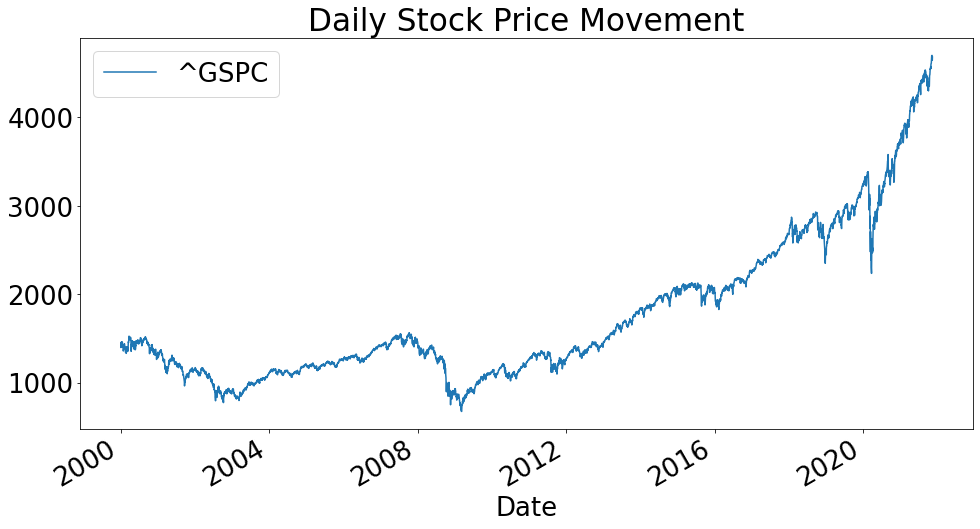

In [29]:
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size":26})
fig, ax = plt.subplots(figsize = (16,8))
adj_close_data.plot.line(ax = ax, legend = True)

ax.set_title("Daily Stock Price Movement")

In [30]:
price_change_data = adj_close_data.pct_change() * 100
price_change_data

,^GSPC
Date,
2000-01-03,NaN
2000-01-04,-3.834467
2000-01-05,0.192218
2000-01-06,0.095568
2000-01-07,2.709040
...,...
2021-11-08,0.088779
2021-11-09,-0.349878
2021-11-10,-0.822582


In [31]:
for df in stock_dict.values():
    print(df["Adj Close"])

Date
2000-01-03    1455.219971
2000-01-04    1399.420044
2000-01-05    1402.109985
2000-01-06    1403.449951
2000-01-07    1441.469971
                 ...     
2021-11-08    4701.700195
2021-11-09    4685.250000
2021-11-10    4646.709961
2021-11-11    4649.270020
2021-11-12    4682.850098
Name: Adj Close, Length: 5503, dtype: float64


In [32]:
stats_df = gather_statistics(price_change_data, 
                             sample = True)
stats_df

,^GSPC
S.D.,1.238
kurtosis,76288.833
mean,0.029
median,0.064
skewness,0.000
variance,1.533


In [33]:
# join the data sets

print ('stock_df.shape():', stock_df.shape)
print ('fed2_df.shape():', fed2_df.shape)


stock_df.shape(): (5503, 6)
fed2_df.shape(): (231, 29)


In [34]:
together = pd.merge(stock_df[['Date', 'Adj Close']],
                   fed2_df[['Date', 'Base: Total ($ Mil)', 
                            'Base: Currency in Circulation ($ Mil)', 
                            'Balance Sheet: Total Assets ($ Mil)',
                            'Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)',
                            'Balance Sheet: Securities Held Outright ($ Mil)',
                            'Balance Sheet: U.S. Treasuries Held Outright ($ Mil)',
                            'Balance Sheet: Federal Agency Debt Securities ($ Mil)',
                            'Balance Sheet: Mortgage-Backed Securities ($ Mil)',
                            'Balance Sheet: Repos ($ Mil)',
                            'Balance Sheet: Central Bank Liquidity Swaps ($ Mil)',
                            'Balance Sheet: Direct Lending ($ Mil)',
                            'Balance Sheet: Unamortized Security Premiums ($ Mil)']],
                   on = ['Date'], how= 'left')

print(together)

KeyError: "['Date'] not in index"

In [ ]:
together.columns = ['Date', 
                    'Adj_Close',
                    'Base: Total ($ Mil)', 
                    'Base: Currency in Circulation ($ Mil)', 
                    'Balance Sheet: Total Assets ($ Mil)',
                    'Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)',
                    'Balance Sheet: Securities Held Outright ($ Mil)',
                    'Balance Sheet: U.S. Treasuries Held Outright ($ Mil)',
                    'Balance Sheet: Federal Agency Debt Securities ($ Mil)',
                    'Balance Sheet: Mortgage-Backed Securities ($ Mil)',
                    'Balance Sheet: Repos ($ Mil)',
                    'Balance Sheet: Central Bank Liquidity Swaps ($ Mil)',
                    'Balance Sheet: Direct Lending ($ Mil)',
                    'Balance Sheet: Unamortized Security Premiums ($ Mil)']



In [ ]:
together = together.dropna(axis=0)
together.tail(20)

In [ ]:
display(".."*100)
display(together.isnull().any())

In [ ]:
corr = together.corr()
print(corr)

In [ ]:
column_names = {'Adj Close':'adj_close',
                'Base: Total ($ Mil)': 'BOGMBASE',
               "Base: Currency in Circulation ($ Mil)": 'WCURCIR',
               # Assets
               "Balance Sheet: Total Assets ($ Mil)": "WALCL",
               "Balance Sheet Securities, Prem-Disc, Repos, and Loans ($ Mil)": "WSRLL",
               "Balance Sheet: Securities Held Outright ($ Mil)": "WSHOSHO",
               ### breakdown of securities holdings ###
               "Balance Sheet: U.S. Treasuries Held Outright ($ Mil)":"WSHOTSL",
               "Balance Sheet: Federal Agency Debt Securities ($ Mil)" : "WSHOFADSL",
               "Balance Sheet: Mortgage-Backed Securities ($ Mil)": "WSHOMCB",
               # other forms of lending
               "Balance Sheet: Repos ($ Mil)": "WORAL",
               "Balance Sheet: Central Bank Liquidity Swaps ($ Mil)" : "SWPT",
               "Balance Sheet: Direct Lending ($ Mil)" : "WLCFLL",
               # unamortized value of securities held (due to changes in interest rates)
               "Balance Sheet: Unamortized Security Premiums ($ Mil)": "WUPSHO",
                }

together = together.rename(columns = column_names)

together

In [ ]:
corr = together.corr()
print(corr)

In [ ]:
# we will plot a heatmap for visualization of correlation matrix

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu')